# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

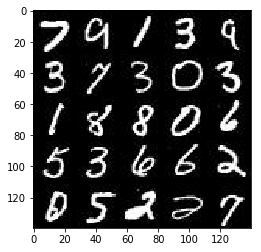

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

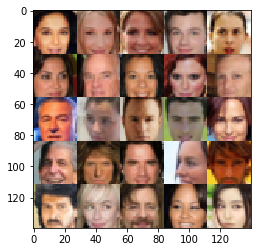

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_image')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    return inputs_image, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    leaky_alpha = 0.2
    stddev = 0.02
    with tf.variable_scope("discriminator", reuse=reuse) as discriminator_scope:
        # Input layer is 28x28x3
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(leaky_alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(leaky_alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(leaky_alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    leaky_alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('generator', reuse=not(is_train)) as generator_scope:
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(leaky_alpha * x1, x1)
        #4x4x512

        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(leaky_alpha * x2, x2)
        #7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(leaky_alpha * x3, x3)
        #14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(logits)
        #28x28xout
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_image, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_image, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                sess.run(d_opt, {input_image: batch_images, input_z: batch_z})
                
                # Run optimizer of generator  twice.
                sess.run(g_opt, {input_z: batch_z})
                sess.run(g_opt, {input_z: batch_z})
                
                # At the end of each epoch, get the losses and print them out
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_image: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.0515... Generator Loss: 0.0658
Epoch 1/2... Discriminator Loss: 2.0713... Generator Loss: 0.1811
Epoch 1/2... Discriminator Loss: 0.4751... Generator Loss: 1.3862
Epoch 1/2... Discriminator Loss: 0.4962... Generator Loss: 1.1742
Epoch 1/2... Discriminator Loss: 0.4203... Generator Loss: 1.6112
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.9436
Epoch 1/2... Discriminator Loss: 3.5564... Generator Loss: 0.2332
Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.6670
Epoch 1/2... Discriminator Loss: 2.1558... Generator Loss: 0.5784
Epoch 1/2... Discriminator Loss: 1.5865... Generator Loss: 0.6412


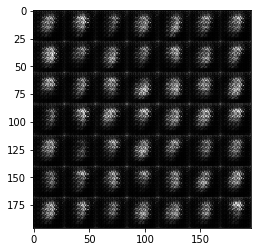

Epoch 1/2... Discriminator Loss: 1.6556... Generator Loss: 0.5229
Epoch 1/2... Discriminator Loss: 0.7686... Generator Loss: 0.9533
Epoch 1/2... Discriminator Loss: 1.6913... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 0.7780
Epoch 1/2... Discriminator Loss: 1.1488... Generator Loss: 0.8779
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 0.8715
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.7706
Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 0.9905
Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 0.8346


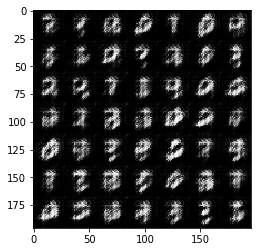

Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.6928
Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 0.8465
Epoch 1/2... Discriminator Loss: 1.2975... Generator Loss: 0.8068
Epoch 1/2... Discriminator Loss: 1.3356... Generator Loss: 0.8808
Epoch 1/2... Discriminator Loss: 1.5917... Generator Loss: 0.5905
Epoch 1/2... Discriminator Loss: 1.5395... Generator Loss: 0.6246
Epoch 1/2... Discriminator Loss: 1.4689... Generator Loss: 0.6804
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 0.8306
Epoch 1/2... Discriminator Loss: 1.7172... Generator Loss: 0.6508
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.7543


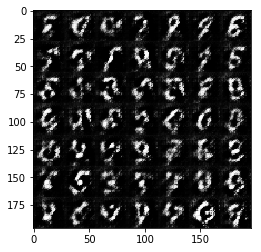

Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.6768... Generator Loss: 1.0997
Epoch 1/2... Discriminator Loss: 1.4324... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.7220
Epoch 1/2... Discriminator Loss: 1.4821... Generator Loss: 0.8185
Epoch 1/2... Discriminator Loss: 1.3032... Generator Loss: 0.7551
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.6301
Epoch 1/2... Discriminator Loss: 1.4732... Generator Loss: 0.6130
Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.5970
Epoch 1/2... Discriminator Loss: 1.5153... Generator Loss: 0.5680


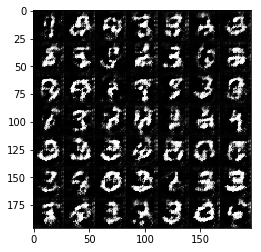

Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 0.7094
Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 0.6279
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.6291
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 0.7785
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 0.8896
Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.5467
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.7801
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 0.5670
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.7826


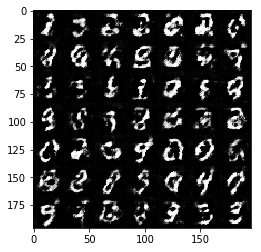

Epoch 2/2... Discriminator Loss: 1.2439... Generator Loss: 0.8498
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.7877
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.3681... Generator Loss: 0.6905
Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.9234
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.7657
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.9525
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.6817
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.6725


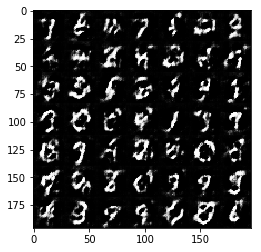

Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.7430
Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 0.6216
Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 0.7458
Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 0.7571
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.7791
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 1.1118
Epoch 2/2... Discriminator Loss: 1.3923... Generator Loss: 0.6370
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 0.6850
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.8690
Epoch 2/2... Discriminator Loss: 1.3925... Generator Loss: 0.6217


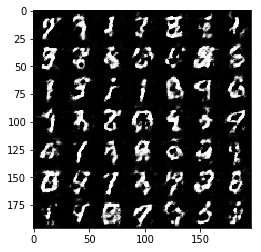

Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.6309
Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 0.8534
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.8363
Epoch 2/2... Discriminator Loss: 1.3761... Generator Loss: 0.8315
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.8609
Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.7842
Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.3354... Generator Loss: 0.7240
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.7604


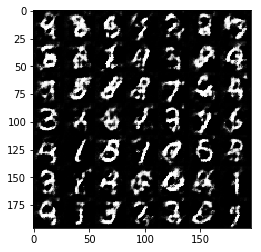

Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.4751... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.7381
Epoch 2/2... Discriminator Loss: 1.5159... Generator Loss: 0.6158
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 1.4523... Generator Loss: 0.7186
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.6766
Epoch 2/2... Discriminator Loss: 1.3682... Generator Loss: 0.6794
Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.9043


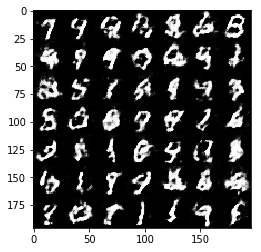

Epoch 2/2... Discriminator Loss: 1.4568... Generator Loss: 0.6163
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.8699
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.7738


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.7706... Generator Loss: 0.0047
Epoch 1/1... Discriminator Loss: 3.2957... Generator Loss: 0.0522
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.3459
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 1.4453


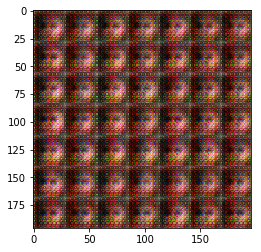

Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7025


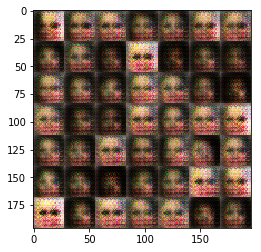

Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.5899... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.8497... Generator Loss: 0.4587
Epoch 1/1... Discriminator Loss: 1.7338... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.7099... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.6804... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.6372... Generator Loss: 0.6371


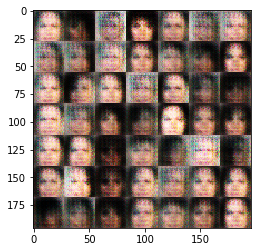

Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.6499... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.5918... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.7109... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.7133... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.5924


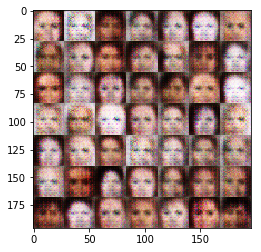

Epoch 1/1... Discriminator Loss: 1.7252... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.7020... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.6529


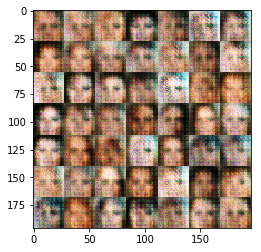

Epoch 1/1... Discriminator Loss: 1.6738... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.6291


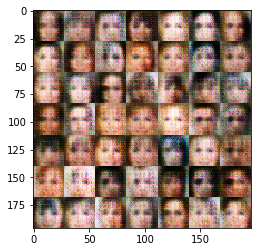

Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.5919... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.6505


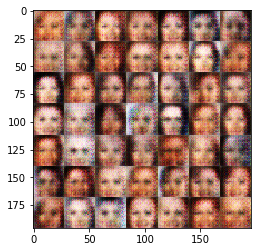

Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.6597


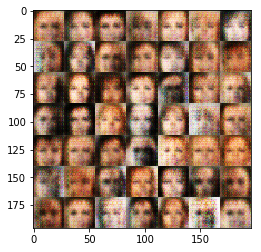

Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.6205


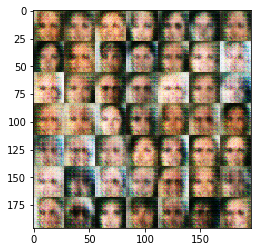

Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6750


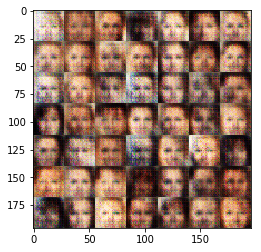

Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6700


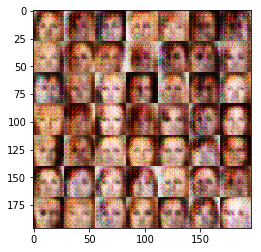

Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6468


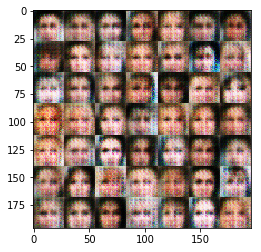

Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6907


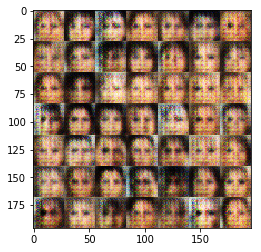

Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.6136


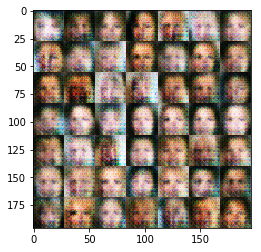

Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6521


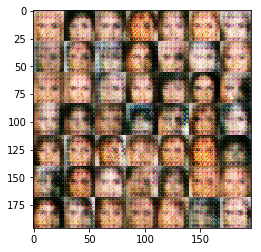

Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6825


In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.